[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ryanfobel/utility-bill-scraper/blob/main/notebooks%2Fcanada%2Fon%2Fkitchener_wilmot_hydro.ipynb)

# Introduction

This notebook will help you to download `pdf` statements and data from a [Kitchener-Wilmot Hydro](https://www.kwhydro.on.ca) account. Launch an interactive version by clicking on the `Open in Colab` badge at the top of this page.

# Download data

To run the notebook, choose `Runtime/Run all` from the menu or press `CTRL`+`F9`. The notebook may promp you for inputs (e.g., authorization to conect to your google drive, username, password). If you're running this in Google Colab, the files will be automatically saved to your Google Drive in the folder `Google Drive/Colab Notebooks/data`.

In [1]:
try:
    import utility_bill_scraper
except ModuleNotFoundError:
    import subprocess
    import sys

    cmd = (
        f"{sys.executable} -m pip install --upgrade --upgrade-strategy "
        "only-if-needed "
        "git+https://github.com/ryanfobel/utility-bill-scraper.git"
    )
    subprocess.check_output(cmd, stderr=subprocess.STDOUT, shell=True).decode("utf-8")

from utility_bill_scraper import install_colab_dependencies

install_colab_dependencies(required_envs=["KWHYDRO_USER", "KWHYDRO_PASSWORD"])

%matplotlib inline

import datetime as dt
import os
import sys

from cycler import cycler
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np

from utility_bill_scraper import LIGHT_COLORMAP
import utility_bill_scraper.canada.on.kitchener_wilmot_hydro as kwh

# Plotting preferences
plt.rc("axes", prop_cycle=cycler("color", LIGHT_COLORMAP))
figsize = (12, 6)
bin_width = 0.9
alpha = 0.5
transparent = False
bbox_inches = "tight"
facecolor = "white"

# Load the `.env` file into the environment if it exists
load_dotenv()

api = kwh.KitchenerWilmotHydroAPI(
    user=os.getenv("KWHYDRO_USER"),
    password=os.getenv("KWHYDRO_PASSWORD"),
    data_path=os.getenv("DATA_PATH", os.path.join("..", "..", "..", "data")),
    google_sa_credentials=os.getenv("GOOGLE_SA_CREDENTIALS"),
    browser=os.getenv("BROWSER", "Firefox"),
)

# Get up to 24 statements (the most recent).
updates = api.update(24)
if updates is not None:
    print(f"{ len(updates) } statements_downloaded")
api.history("monthly").tail()

0 statements_downloaded


,Total,Off Peak Consumption,Mid Peak Consumption,On Peak Consumption,Off Peak Rate,Mid Peak Rate,On Peak Rate,Total Consumption
Date,,,,,,,,
2021-07-26,104.18,459.60,149.01,115.61,0.082,0.170,0.113,724.22
2021-08-25,93.69,356.50,126.59,126.09,0.082,0.170,0.113,609.18
2021-09-23,99.80,438.80,128.16,116.26,0.082,0.170,0.113,683.22
2021-10-20,92.14,387.96,133.76,96.00,0.082,0.113,0.170,617.72
2021-11-10,199.14,436.48,170.30,127.46,0.082,0.113,0.170,734.24


## Monthly electricity consumption history

<Figure size 432x288 with 0 Axes>

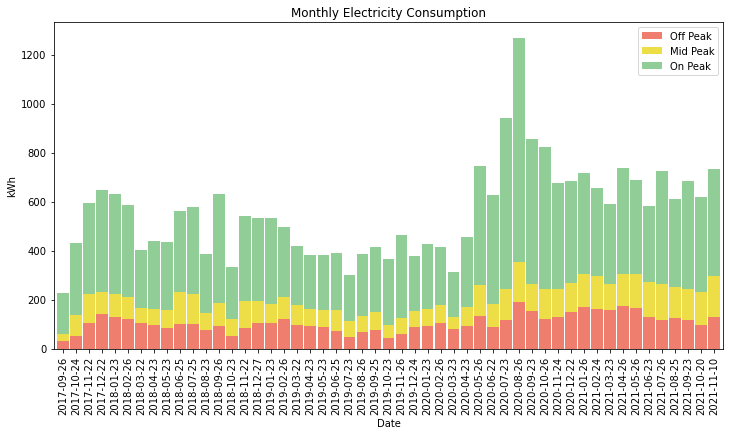

In [2]:
df = api.history("monthly")

plt.figure()
df[["On Peak Consumption", "Mid Peak Consumption", "Off Peak Consumption"]].plot.bar(
    stacked=True,
    width=bin_width,
    color=["#F07E6E", "#EDDD46", "#90CD97"],
    figsize=figsize,
)
plt.ylim((0, None))
plt.title("Monthly Electricity Consumption")
plt.ylabel("kWh")
plt.legend(["Off Peak", "Mid Peak", "On Peak", "Total"])
os.makedirs("images", exist_ok=True)
plt.savefig(
    os.path.join("images", "monthly_electricity_consumption.png"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

## Annual CO2 emissions

annual electricity usage: 8019.3 kWh
annual electricity cost: $1268.59
annual CO2 emissions from electricity: 617.49 kg


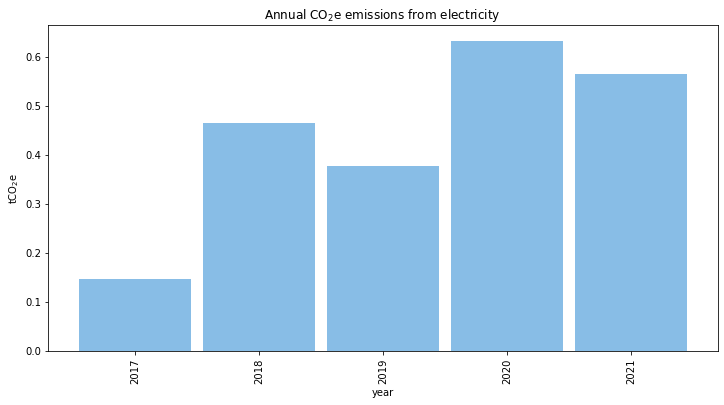

In [3]:
# Carbon intensity of electricity generation in Ontario (40-77 g CO2 / kWh)
# * 40 g / kWh (https://www.neb-one.gc.ca/nrg/sttstc/lctrct/rprt/
#               2017cndrnwblpwr/ghgmssn-eng.html)
# * 77 g / kWh (https://www.conferenceboard.ca/hcp/provincial/environment/
#               low-emitting-electricity-production.aspx)
# * This is likely to go up when Pickering is closed
#   https://www.opg.com/darlington-refurbishment/Documents/IntrinsikReport_GHG_OntarioPower.pdf

carbon_intensity_kgCO2_per_kwh = 0.077

plt.figure(figsize=figsize)
df["kgCO2"] = df["Total Consumption"] * carbon_intensity_kgCO2_per_kwh
df["year"] = [int(x[0:4]) for x in df.index]
df["month"] = [int(x[5:7]) for x in df.index]
(df.groupby("year").sum()["kgCO2"] / 1e3).plot.bar(width=bin_width)
plt.title("Annual CO$_2$e emissions from electricity")
plt.ylabel("tCO$_2$e")
os.makedirs("images", exist_ok=True)
plt.savefig(
    os.path.join("images", "annual_co2_emissions_electricity.png"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

print("annual electricity usage: %.1f kWh" % (df["Total Consumption"].iloc[-12:].sum()))
print("annual electricity cost: $%.2f" % (df["Total"].iloc[-12:].sum()))
print(
    "annual CO2 emissions from electricity: %.2f kg"
    % (df["Total Consumption"].iloc[-12:].sum() * carbon_intensity_kgCO2_per_kwh)
)

## CO2 emissions vs previous year

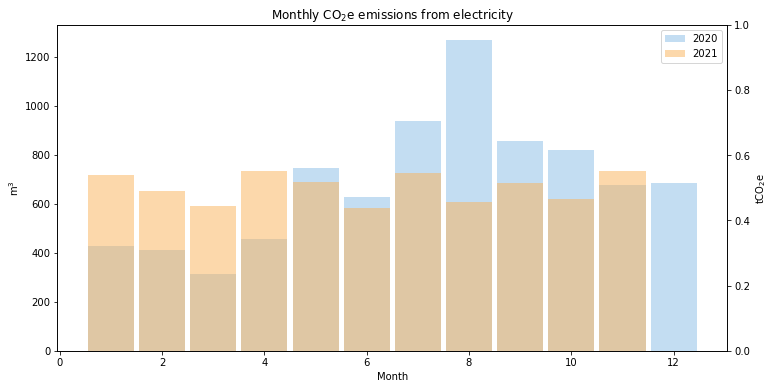

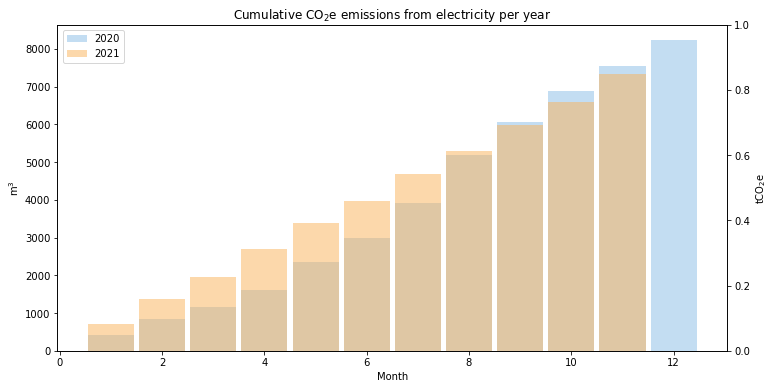

In [4]:
n_years_history = 1

plt.figure(figsize=figsize)
for year, df_year in df.groupby("year"):
    if year >= dt.datetime.utcnow().year - n_years_history:
        df_year.sort_values("month", inplace=True)
        plt.bar(
            df_year["month"],
            df_year["Total Consumption"],
            label=year,
            width=bin_width,
            alpha=alpha,
        )
plt.legend()
plt.ylabel("m$^3$")
plt.xlabel("Month")
ylim = plt.ylim()
ax = plt.gca()
ax2 = ax.twinx()
plt.ylabel("tCO$_2$e")
plt.title("Monthly CO$_2$e emissions from electricity")
os.makedirs("images", exist_ok=True)
plt.savefig(
    os.path.join("images", "monthly_co2_emissions_electricity.png"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

plt.figure(figsize=figsize)
for year, df_year in df.groupby("year"):
    if year >= dt.datetime.utcnow().year - n_years_history:
        df_year.sort_values("month", inplace=True)
        plt.bar(
            df_year["month"],
            np.cumsum(df_year["Total Consumption"]),
            label=year,
            width=bin_width,
            alpha=alpha,
        )
plt.legend()
plt.ylabel("m$^3$")
plt.xlabel("Month")
ylim = plt.ylim()
ax = plt.gca()
ax2 = ax.twinx()
plt.ylabel("tCO$_2$e")
plt.title("Cumulative CO$_2$e emissions from electricity per year")
os.makedirs("images", exist_ok=True)
plt.savefig(
    os.path.join("images", "cumulative_co2_emissions_electricity.png"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)